In [15]:
from torch.autograd import Variable
import torch
import torch.autograd
import torch.nn.functional as F
import random
import numpy as np
from params_poly import p
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm
import pickle as pkl
from os.path import join as oj
import numpy.random as npr

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab




def set_style():
    plt.style.use('fivethirtyeight')
    label_size = 12
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    mpl.rcParams['axes.labelsize'] = label_size
    mpl.rcParams['axes.titlesize'] = label_size
    mpl.rcParams['figure.titlesize'] = label_size
    mpl.rcParams['lines.markersize'] = 20
    mpl.rcParams['lines.linewidth'] = 3.
    mpl.rcParams['grid.linewidth'] = 1.
    mpl.rcParams['legend.fontsize'] = label_size
    pylab.rcParams['xtick.major.pad']=3
    pylab.rcParams['ytick.major.pad']=3

    pylab.rcParams['figure.facecolor']='white'
    pylab.rcParams['axes.facecolor']='white'
    # mpl.rcParams['figure.figsize'] = [12, 10]
    # mpl.rcParams.keys()
    # Say, "the default sans-serif font is COMIC SANS"
    # mpl.rcParams['font.serif'] = 'Times New Roman'
    # # Then, "ALWAYS use sans-serif fonts"
    # mpl.rcParams['font.family'] = "Serif"

import pandas as pd
from copy import deepcopy

In [3]:
set_style()

In [7]:
def square_el(x):
    return x * x

def cube_el(x):
    return x * x * x

def sin_el(x):
    return np.sin(x * 2 * np.pi / 100)

def make_data(func, N=4):
    X = np.linspace(0, 100, N)
    X_grid = np.linspace(-80, 120, 1000)
    Y = np.apply_along_axis(func, 0, X)
    Y_grid = np.apply_along_axis(func, 0, X_grid)            
    return X, Y, X_grid, Y_grid


def seed(p, repeat):
    s = p.seed + repeat * 13913
    # set random seed        
    np.random.seed(s) 
    torch.manual_seed(s)    
    random.seed(s)
    
## network
class LinearNet(nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, output_size):
        # num_layers is number of weight matrices
        super(LinearNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # for one layer nets
        if num_layers == 1:
            self.fc = nn.ModuleList([nn.Linear(input_size, output_size)])
        else:
            self.fc = nn.ModuleList([nn.Linear(input_size, hidden_size)])
            self.fc.extend([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 2)])
            self.fc.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        y = x.view(-1, self.input_size)
        for i in range(len(self.fc) - 1):
            y = F.relu(self.fc[i](y))
        return self.fc[-1](y)

# run

In [115]:
def simple_data(d, N):
    X = npr.randn(N, d)
    Y = X[:, 0]
    return X, Y

hidden_size = 4
repeats = 1
opt = 'sgd'
lr = 1e-2
N = 1
d = 2 # number of input features
num_iters = 1000



X, Y = simple_data(d, N)
# func = cube_el # square
# X, Y, X_grid, Y_grid = make_data(func, N)
# plt.plot(X[:, 0], Y, 'o')
# plt.plot(X_grid, Y_grid, '--')

device = 'cuda'
X_t, Y_t = torch.Tensor(X).to(device), torch.Tensor(Y).to(device)
r = {'model': [], 'num_hidden': [], 
     'loss': [], 'seed': [], 'opt': [], 'lr': []}


for i, nh in tqdm(enumerate([1, 2, 6])):
    for repeat in range(repeats):
        seed(p, repeat)
        model = LinearNet(num_layers=nh, input_size=d, hidden_size=hidden_size, output_size=1).to(device)

        if opt == 'adam':
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                              lr=lr) # wow Adam does way better
        else:
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr) # 1e6 worked 
        criterion =  torch.nn.MSELoss()
        losses = []
        for batch_idx in range(num_iters):
            optimizer.zero_grad()
            loss = criterion(model(X_t), Y_t)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
#         print('loss: {:.6f} after {} batches'.format(loss.data[0], batch_idx))

        
        # saving
        r['model'].append(deepcopy(model))
        r['num_hidden'].append(nh)
        r['loss'].append(losses)
        r['seed'].append(repeat)
        r['opt'].append(opt)
        r['lr'].append(lr)


print('done!')

3it [00:06,  2.17s/it]

done!


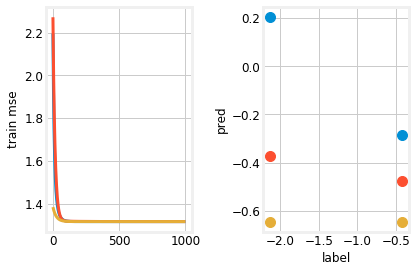

In [116]:
# d = {'model': models, 'num_hidden': num_hiddens, 
# results.to_pickle('poly_runs_sin.pkl')
# pkl.dump(d, open('poly_runs_sin' + '.pkl', 'wb'))

results = pd.DataFrame.from_dict(r)       
# results = pd.read_pickle('poly_runs.pkl')
results

X, Y = simple_data(d, N)

R, C = 1, 2
for i, row in results.iterrows():
    plt.subplot(R, C, 1)
    plt.plot(row.loss)
    plt.ylabel('train mse')
    m = row.model    
    plt.subplot(R, C, 2)
    pred = m(torch.Tensor(X).to(device)).cpu().detach().numpy()
    plt.plot(Y, pred, '.')
    plt.ylabel('pred')
    plt.xlabel('label')
    
plt.tight_layout()
plt.show()